# Models for HR analytics at "Careful Work" company

The "Careful Work" company has provided data containing various characteristics of its employees, including their job satisfaction level. This information was obtained through feedback forms: employees complete a questionnaire, and their satisfaction level is calculated as a proportion from 0 to 1, where 0 means completely dissatisfied, and 1 means fully satisfied.  
Gathering data through these surveys isn't easy: the company is large, and every employee needs to be notified about the survey and then followed up to ensure completion.  
In this regard, several tasks were set:  
* **First**, to build a model capable of predicting an employee's job satisfaction level based on client data. Job satisfaction directly impacts employee turnover, and predicting turnover is one of the most important tasks for HR analysts. Sudden resignations carry risks for the company, especially if a key employee leaves.  
* **The second** task is to build a model that can predict if an employee will leave the company based on client data.

<a id='Contents'></a>
**Project Contents**  
[Task 1: Data Loading](#Task-1-Data-Loading)\
[Task 1: Data Preprocessing](#Task-1-Data-Preprocessing)\
[Task 1: Exploratory Data Analysis](#Task-1-Exploratory-Data-Analysis)\
[Task 1: Data Preparation](#Task-1-Data-Preparation)\
[Task 1: Model Training](#Task-1-Model-Training)\
[Task 1: Conclusion](#Task-1-Conclusion)

[Task 2: Data Loading](#Task-2-Data-Loading)\
[Task 2: Data Preprocessing](#Task-2-Data-Preprocessing)\
[Task 2: Exploratory Data Analysis](#Task-2-Exploratory-Data-Analysis)\
[Task 2: Adding a New Input Feature](#Task-2-Adding-a-New-Input-Feature)\
[Task 2: Data Preparation](#Task-2-Data-Preparation)\
[Task 2: Model Training](#Task-2-Model-Training)\
[Task 2: Conclusion](#Task-2-Conclusion)

[Overall Conclusion](#Overall-Conclusion)

In [1]:
%%capture
!pip install shap
!pip install phik
#!pip install numpy==1.26.0
!pip install --upgrade matplotlib seaborn scikit-learn scipy pandas shap

In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
# import libraries before starting project with one block
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st

# load class pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

#load classes for data preparation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# load class for working with gaps
from sklearn.impute import SimpleImputer

# load function for working with metrics
from sklearn.metrics import roc_auc_score, make_scorer
#from sklearn.inspection import permutation_importance

# import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# load models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

# tests for checking correlations
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

import shap


In [ ]:
# bring alone the block with settings and functions

# set the standard dataframe before loading
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.mode.chained_assignment = None # Warning while column access to DataFrame is exhausting 

try:
    pd.set_option('future.no_silent_downcasting', True)
except:
    pass

# print the information about the structure and data of each dataframe
def get_info(dataset):
    display(dataset.info(), dataset.head(5), dataset.tail(5))


# print of histogram and boxplot
def hist_box(data,column,hue=None):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
    
    if hue == None:
        
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     legend='auto', ax=ax)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(7, 2)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=10, 
                     color=random_color,
                     alpha=0.6,
                     hue=hue, 
                     multiple='stack',
                     legend='auto', ax=ax)
        

    ax = axes[1]
    sns.boxplot(x=data[column], color=random_color, ax=ax)
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show();


# function for calculating absolute values for indicating on the pie chart
def absolute_value(val,df):
    a = round(val/100.*df.sum())
    return a

# function for building a pie chart
def pieplot(data,column):
    data_grouped = data.groupby(column)[column].count()
    data.groupby(column)[column].count().plot(kind='pie', 
             title ='Признак {}\n'.format(column),
             radius=1.3,
             ylabel='',
             autopct=lambda x: f'{x:.1f}%({absolute_value(x, data_grouped)})');
    
# build a function for evaluating the quality of the model by the SMAPE metric
def SMAPE_metric(y_true, y_pred):
    
    #y_true = y_true.values.ravel()
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    metric = (100/len(y_true)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) /2))
    return metric

<a id='Task-1.-Loading-data'></a>
## Task 1: Loading Data
[Back to contents](#To-contents)

In [ ]:
# import data for task 1
try:
    data1_train = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_1/train_job_satisfaction_rate.csv')
    data1_test_f = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_1/test_features.csv') 
    data1_test_t = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_1/test_target_job_satisfaction_rate.csv')
except:
    data1_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    data1_test_f = pd.read_csv('/datasets/test_features.csv')
    data1_test_t = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')    


In [ ]:
# take a look at the data
get_info(data1_train)
get_info(data1_test_f)
get_info(data1_test_t);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.580
1,653870,hr,junior,high,2,no,no,5,38400,0.760
2,184592,sales,junior,low,1,no,no,2,12000,0.110
3,171431,technology,junior,low,4,no,no,2,18000,0.370
4,693419,hr,junior,medium,1,no,no,3,22800,0.200


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.450
3996,957499,sales,junior,medium,2,no,no,4,21600,0.680
3997,533318,sales,middle,low,7,no,no,5,24000,0.760
3998,706868,sales,junior,medium,2,no,no,3,24000,0.480
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.180


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.740
1,825977,0.750
2,418490,0.600
3,555320,0.720
4,826430,0.080


,id,job_satisfaction_rate
1995,405257,0.280
1996,370925,0.210
1997,857722,0.390
1998,303402,0.260
1999,648995,0.620


**Conclusion**

Based on preliminary assessment of the loaded data:

* No corrections to column names or text values are required.
* Conversion of data types to suitable formats for analysis is not necessary, but it is possible to convert int64/float64 to int32/float32 to save memory space.
* It is also necessary to perform checks on the original data for missing values and duplicates in order to eliminate them later.

<a id='Task-1.-Data-preprocessing'></a>
## Task 1: Data Preprocessing
[Back to contents](#To-contents)

Based on the conclusions from the previous section, we will examine and correct (if necessary) each of the comments in order:

In [7]:
for column in data1_train.columns:
    display(data1_train[column].unique())

array([155278, 653870, 184592, ..., 533318, 706868, 338347])

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'high', 'low'], dtype=object)

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array([1, 5, 2, 3, 4])

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200])

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

In [8]:
data1_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [ ]:
# look at missing values in both columns
display(data1_train[data1_train.isna().any(axis=1)])

# save ids of these records for checking
ids1 = data1_train[data1_train['dept'].isna()]['id']
ids2 = data1_train[data1_train['level'].isna()]['id']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.660
1469,416327,sales,NaN,low,1,no,no,5,18000,0.730
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.620
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.880
1633,475114,NaN,junior,high,4,no,no,4,31200,0.630
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.300
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.710
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.280
2975,168668,NaN,junior,low,3,no,no,4,18000,0.880
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.540


In [ ]:
# make pipline, which includes only SimpleImputer function
si_pipe = Pipeline(
    [('simpleImputer_', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ])


# apply pipeline to needed columns
data1_train[['dept', 'level']] = si_pipe.fit_transform(data1_train[['dept', 'level']])


In [ ]:
# check for missing values
display('Missing values in column dept', data1_train[data1_train['id'].isin(ids1)])
display('Missing values in column level', data1_train[data1_train['id'].isin(ids2)])

'Пропуски в столбце dept'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,sales,junior,medium,5,no,no,4,21600,0.620
1630,814624,sales,junior,medium,3,no,no,4,24000,0.880
1633,475114,sales,junior,high,4,no,no,4,31200,0.630
2781,497243,sales,junior,medium,1,no,no,3,26400,0.280
2975,168668,sales,junior,low,3,no,no,4,18000,0.880
3866,641150,sales,junior,low,3,no,yes,4,12000,0.540


'Пропуски в столбце level'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,junior,medium,1,no,no,4,27600,0.660
1469,416327,sales,junior,low,1,no,no,5,18000,0.730
1745,135043,sales,junior,medium,1,no,no,3,26400,0.300
2522,998838,sales,junior,medium,1,no,no,5,27600,0.710


In [ ]:
# replace the typos in the level column
data1_train['level'] = data1_train['level'].replace('sinior', 'senior')

# change the numerical data types to less voluminous
data1_train[['id','employment_years','supervisor_evaluation','salary']] = data1_train[['id','employment_years','supervisor_evaluation','salary']].astype(np.int32)
data1_train['job_satisfaction_rate'] = data1_train['job_satisfaction_rate'].astype(np.float32)

# print checking after changes
display(data1_train['level'].unique(),
        data1_train.isna().sum())
data1_train.info()

array(['junior', 'middle', 'senior'], dtype=object)

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int32  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int32  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int32  
 8   salary                 4000 non-null   int32  
 9   job_satisfaction_rate  4000 non-null   float32
dtypes: float32(1), int32(4), object(5)
memory usage: 234.5+ KB


In [ ]:
# checking data in test set of input features

for column in data1_test_f.columns:
    display(data1_test_f[column].unique())

array([485046, 686555, 467458, ..., 305653, 160233, 771859])

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array([5, 4, 3, 1, 2])

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400])

In [ ]:
# replace spaces with NaN
data1_test_f[['dept','workload']] = data1_test_f[['dept','workload']].replace(' ', np.nan)

# and replace missing values with the most frequent values
si_pipe.fit(data1_train[['dept', 'level','workload']])
data1_test_f[['dept','level','workload']] = si_pipe.transform(data1_test_f[['dept','level','workload']])

# replace misspelled values in the level column
data1_test_f['level'] = data1_test_f['level'].replace('sinior', 'senior')

# change numeric types to less voluminous
data1_test_f[['id','employment_years','supervisor_evaluation','salary']] = data1_test_f[['id','employment_years','supervisor_evaluation','salary']].astype(np.int32)


In [ ]:
#print checks after changes
display(data1_test_f['level'].unique(),
        data1_test_f.isna().sum())
data1_test_f.info()

array(['junior', 'middle', 'senior'], dtype=object)

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int32 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int32 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int32 
 8   salary                 2000 non-null   int32 
dtypes: int32(4), object(5)
memory usage: 109.5+ KB


In [ ]:
# in the third dataset, we change the types of numerical data
data1_test_t['id'] = data1_test_t['id'].astype(np.int32)
data1_test_t['job_satisfaction_rate'] = data1_test_t['job_satisfaction_rate'].astype(np.float32)

data1_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int32  
 1   job_satisfaction_rate  2000 non-null   float32
dtypes: float32(1), int32(1)
memory usage: 15.8 KB


In [ ]:
# check that all test input features ids match target ids, count matches
data1_test_t['id'].isin(data1_test_f['id']).sum()

2000

In [ ]:
# and then sort by id, so that we don't accidentally get the wrong order
data1_test_t = data1_test_t.sort_values(by='id').reset_index(drop=True)
data1_test_f = data1_test_f.sort_values(by='id').reset_index(drop=True)

display(data1_test_t.head(),
        data1_test_f.head())

,id,job_satisfaction_rate
0,100298,0.800
1,100480,0.840
2,100503,0.790
3,100610,0.750
4,100692,0.690


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [ ]:
# checking for duplicates
display(data1_train.duplicated().sum(),
        data1_test_f.duplicated().sum(),
        data1_test_t.duplicated().sum())

0

0

0

**Conclusion**

As part of the data preprocessing for Task 1:

* Several missing values were identified and replaced with the most frequently occurring values in that column.
* Typos in text values were corrected.
* The types of numeric data were adjusted to be less memory-intensive.
* A check was performed for both explicit and implicit duplicates - none were found.
* The order of records in the test dataframes was revised.

## Task 1: Exploratory Data Analysis
<a id='Task-1.-Exploratory-Data-Analysis'></a>
[Back to contents](#To-contents)

First, we will examine the standard statistics for the tables and the distributions of the data:

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.580
1,653870,hr,junior,high,2,no,no,5,38400,0.760


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000,4000.000,4000.000,4000.000,4000.000
mean,544957.621,3.719,3.477,33926.700,0.534
std,257883.105,2.543,1.009,14900.704,0.225
min,100954.000,1.000,1.000,12000.000,0.030
25%,322836.750,2.000,3.000,22800.000,0.360
50%,534082.500,3.000,4.000,30000.000,0.560
75%,771446.000,6.000,4.000,43200.000,0.710
max,999521.000,10.000,5.000,98400.000,1.000


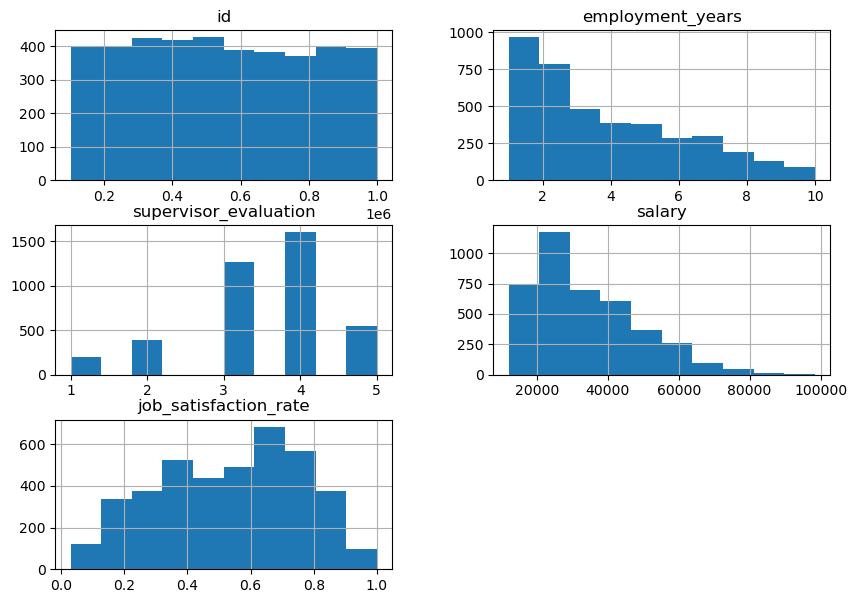

In [ ]:
display(data1_train.head(2))

# take a look at the distribution of data in general
data1_train.hist(figsize=(10, 7));
display(data1_train.describe())


In the data1_train table, the numerical data appears to be "non-normal", and the feature 'supervisor_evaluation' seems to be a categorical ordered feature because it has 5 options with an ordinal structure - from lowest evaluation to highest.

No outliers or anomalies are observed; we will examine these features separately and also look at the categorical features.

Распределение количественных переменных



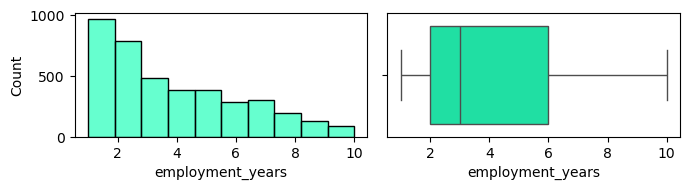

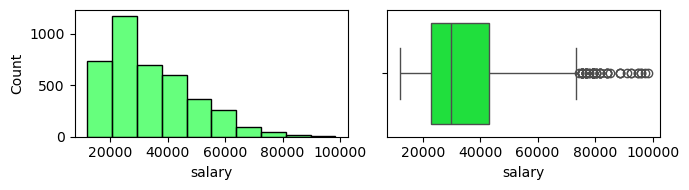

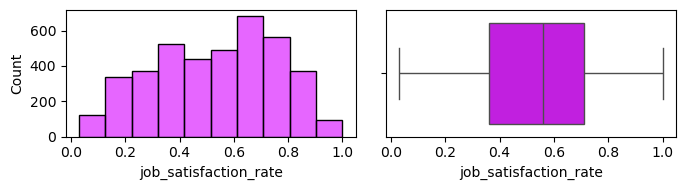

In [ ]:
# build histograms and boxplots for quantitative variables
columns_num = ['employment_years', 'salary','job_satisfaction_rate']

print('Distribution of quantitative variables\n')

for index, column in enumerate(columns_num):
    hist_box(data1_train,column)
    

No critical anomalies were found in the quantitative features that need to be addressed, although there are some outliers in the "salary" feature that appear to represent a distinct group of experienced employees with high salaries - data about which would be important for training models.

In general, the main body of employees are junior staff with limited experience and corresponding low salaries. Let's check this on categorical features:

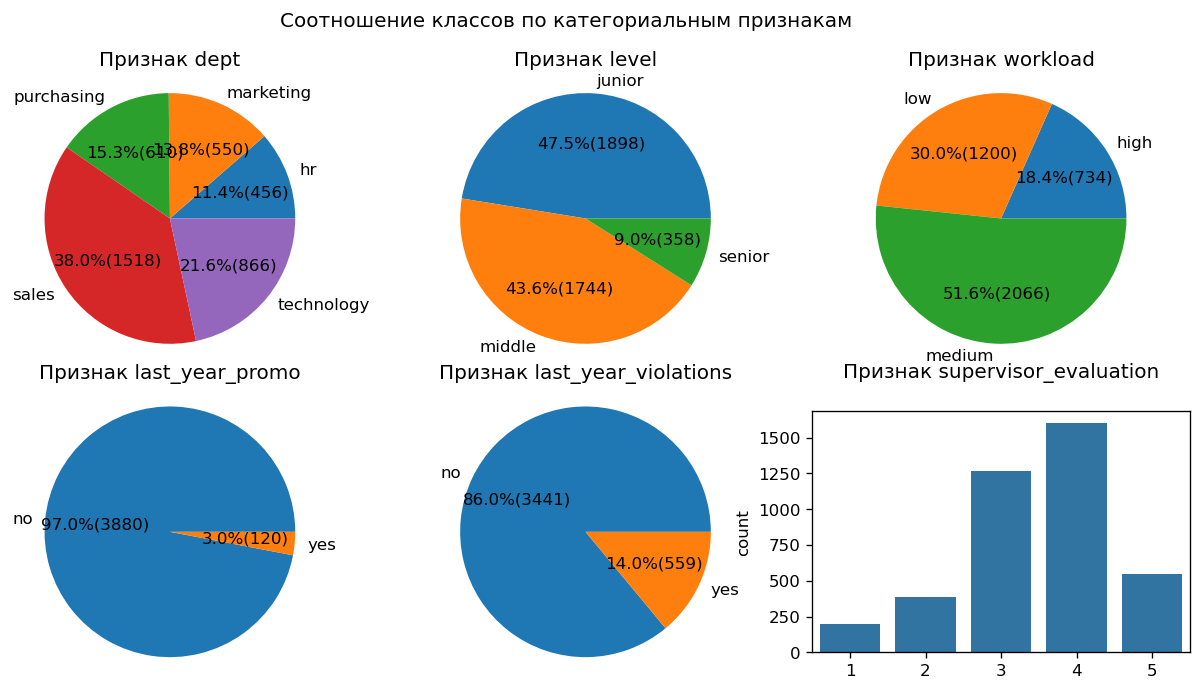

In [ ]:
# build pieplots on categorical data
columns_cat = ['dept', 'level','workload','last_year_promo','last_year_violations']

plt.figure(figsize=[13, 6], dpi=120)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.suptitle('The distribution of classes based on categorical features:', y=1)

for i,column in enumerate(columns_cat):
    
    plt.subplot(2,3,i+1)
    pieplot(data1_train,column)

plt.subplot(2,3,6)
sns.countplot(data=data1_train,x='supervisor_evaluation')
plt.title('Feature supervisor_evaluation', pad=20)
plt.xlabel('')
plt.show()

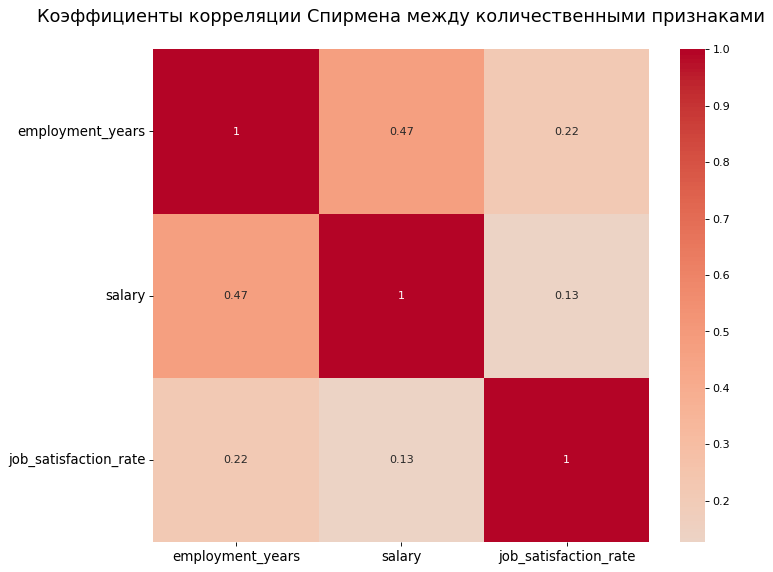

In [ ]:
# build correlation matrices

# as we have non-normal distribution we will use Spearman's coefficient
plt.figure(figsize=(10,8), dpi= 80)
sns.heatmap(data1_train[['employment_years', 'salary','job_satisfaction_rate']].corr(method='spearman'), 
                        xticklabels=data1_train[['employment_years', 'salary','job_satisfaction_rate']].corr(method='spearman').columns, 
                        yticklabels=data1_train[['employment_years', 'salary','job_satisfaction_rate']].corr(method='spearman').columns, 
                        cmap='coolwarm' , 
                        center=0, 
                        annot=True)

plt.title('Pearson correlation coefficients between quantitative features:\n', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()


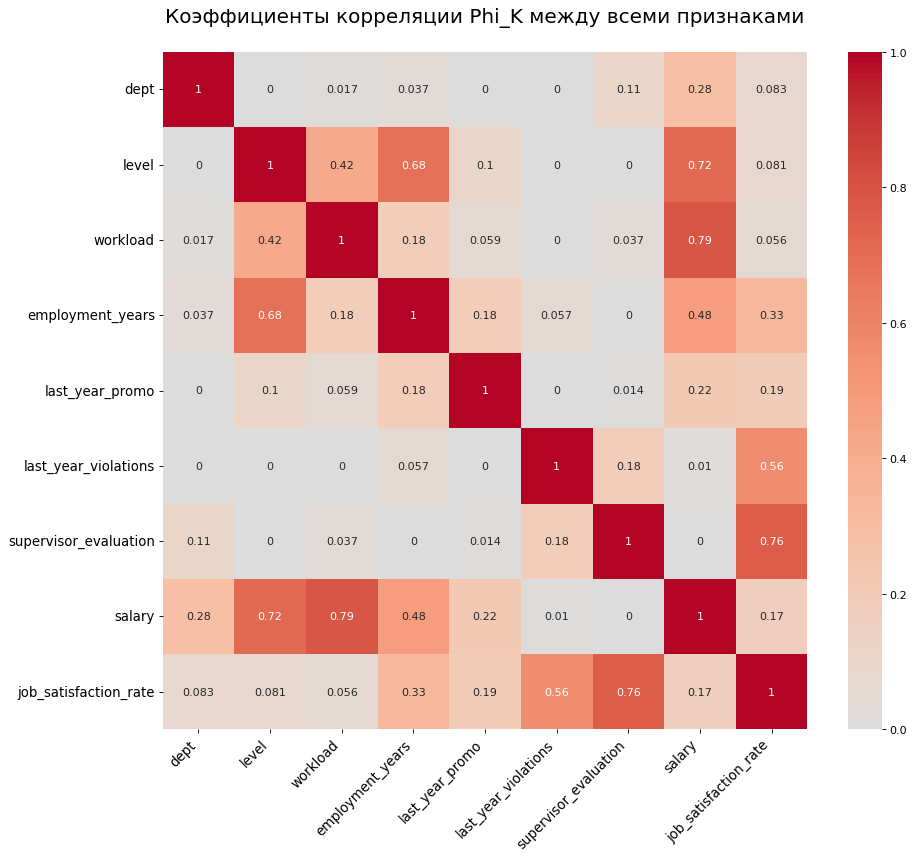

In [ ]:
# calculation of the correlation matrix using the Phi_K coefficient
mf = data1_train.drop('id', axis=1)
phik_matrix = mf.phik_matrix(interval_cols=['employment_years', 'salary','job_satisfaction_rate'])

# will look at the heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, cmap='coolwarm', center=0, annot=True)

plt.title('Phi_K correlation coefficients between all features:\n', fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

We will also immediately check the test dataset for anomalies:

Распределение количественных переменных:



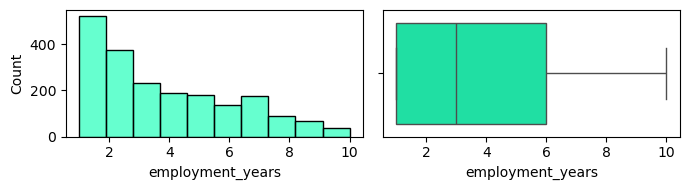

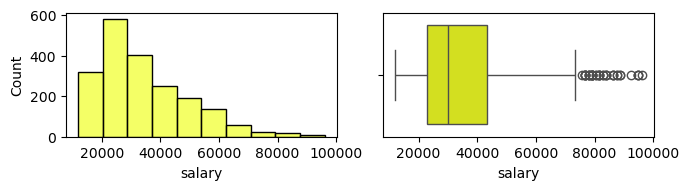

In [ ]:
# buildd histograms and boxplots for quantitative variables of test sample
columns_num = ['employment_years', 'salary']

print('Distribution of quantitative variables:\n')

for index, column in enumerate(columns_num):
    hist_box(data1_test_f,column)
    

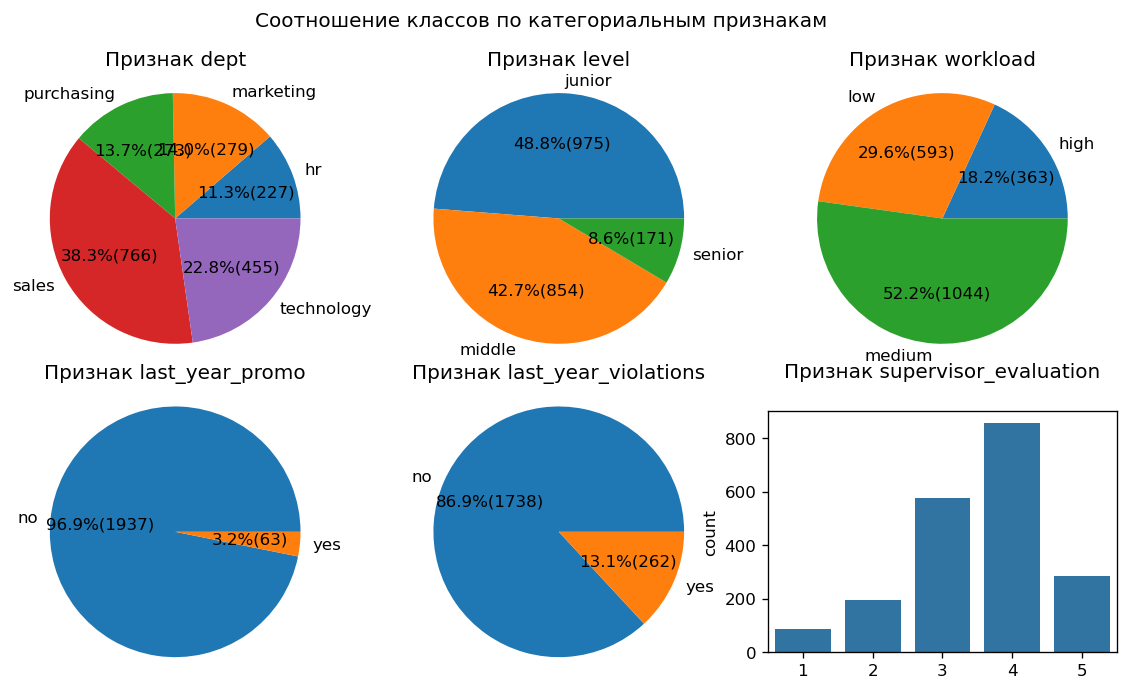

In [ ]:
# build pieplot on categorical data of test sample
columns_cat = ['dept', 'level','workload','last_year_promo','last_year_violations']

plt.figure(figsize=[12, 6], dpi=120)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.suptitle('The distribution of classes based on categorical features in the test dataset:', y=1)

for i,column in enumerate(columns_cat):
    
    plt.subplot(2,3,i+1)
    pieplot(data1_test_f,column)

plt.subplot(2,3,6)
sns.countplot(data=data1_test_f,x='supervisor_evaluation')
plt.title('Feature supervisor_evaluation', pad=20)
plt.xlabel('')
plt.show()

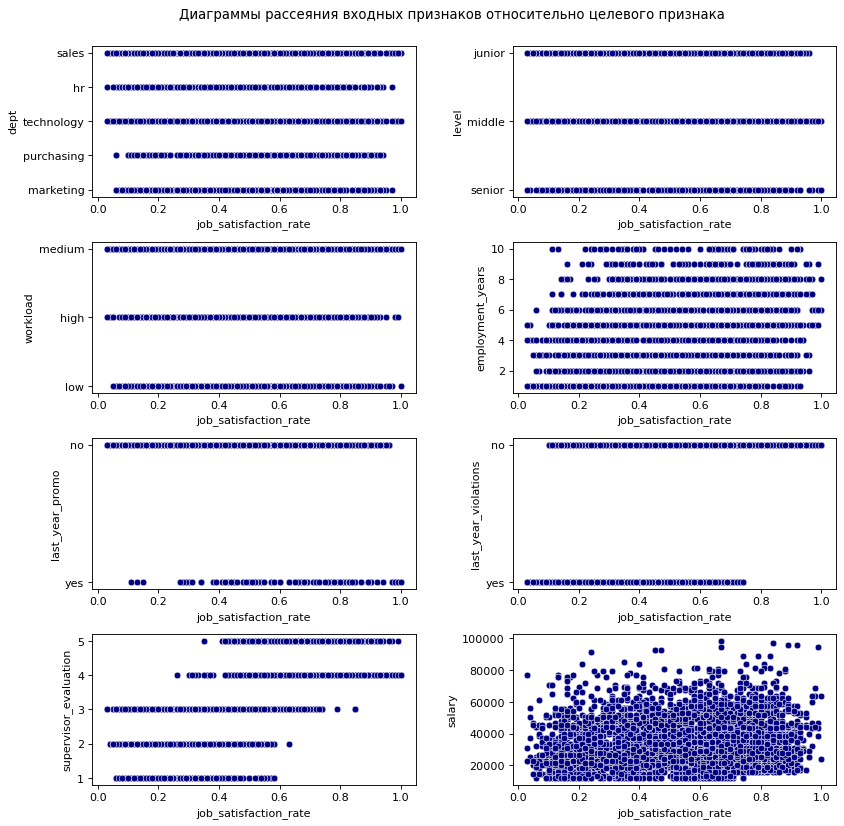

In [ ]:
# build scatter plots for checking linearity of input features with target
data_temp = data1_train.drop('id', axis=1)

plt.figure(figsize=(12,12), dpi= 80)    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle('Scatter plots of input features relative to the target feature:', y=0.92)

for i,n_feature in enumerate(data_temp.columns):   
    if n_feature != 'job_satisfaction_rate':
        print()
        plt.subplot(4,2,i+1)
        sns.scatterplot(x='job_satisfaction_rate', y=n_feature, data=data_temp, color='navy')
plt.show();

**Conclusion**

The quantitative data in the training dataset are distributed non-normally, with outliers present in the salary feature, which confirms the presence of a segment of higher-paid employees in the senior category.  
Due to the large difference in ranges between features (from 0 to 1 and from 1 to 10), it is essential to scale the data during preparation for training.   
The categorical data have 2-5 classes with uneven distributions, and features 'level', 'workload', and 'supervisor_evaluation' have an ordinal nature, requiring pre-processing using OrdinalEncoder taking into account the order of categories.  
Other features are non-hierarchical and require One-Hot Encoding (OHE) to train models that may include linear ones (since linear models are sensitive to categorical coding that does not consider order).  
The Pearson correlation coefficients between quantitative data and the target feature showed a weak link with an age feature at 0.22 and salary feature at 0.13.  
When checking the correlation level using Phi_K metric, significant links were found only with supervisor evaluation (0.76) and number of violations (0.56), and with the number of years worked (0.33).  
Among the input features, significant connections were observed between job levels, salaries, years worked, and workload levels, but no multicollinearity was detected.  
The linearity of connections between input features and the target variable is not established.

The data in the test dataset are distributed similarly to the training data; there are no additional comments.

## Task 1: Data Preparation
<a id='Task-1.-Data-Preparation'></a>
[Back to contents](#To-contents)

In [ ]:
# form the training and test sets with the dataset already available for test data
X_train = data1_train.drop(['id','job_satisfaction_rate'], axis=1)
y_train = pd.DataFrame(data1_train['job_satisfaction_rate'], columns=['job_satisfaction_rate'])
X_test = data1_test_f.drop('id', axis=1) 
y_test = data1_test_t.drop('id', axis=1) 
                           
display(X_train.head(),
       X_test.head(),
       y_train.head(),
       y_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,hr,junior,low,2,no,no,4,19200
1,marketing,junior,low,4,no,no,4,16800
2,purchasing,middle,high,5,no,no,4,55200
3,sales,middle,medium,5,no,no,4,43200
4,sales,middle,high,6,no,no,4,48000


,job_satisfaction_rate
0,0.580
1,0.760
2,0.110
3,0.370
4,0.200


,job_satisfaction_rate
0,0.800
1,0.840
2,0.790
3,0.750
4,0.690


In [ ]:
# make a list of feature names
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level','workload','supervisor_evaluation']
num_columns = ['employment_years','salary']

# make pipeline for preparation of features from list ohe_columns: filling in the gaps and OHE-encoding
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# make pipeline for preparation of features from list ord_columns: filling in the gaps and Ordinal-encoding
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low','medium','high'],
                    [1,2,3,4,5]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# make a common pipeline for preparation of data
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [ ]:
# count quantity of features after preprocessing
max_features = data_preprocessor.fit_transform(X_train).shape[1]
display(max_features)

# take a look at the column names after encoding
display(data_preprocessor.get_feature_names_out())

11

array(['ohe__dept_marketing', 'ohe__dept_purchasing', 'ohe__dept_sales',
       'ohe__dept_technology', 'ohe__last_year_promo_yes',
       'ohe__last_year_violations_yes', 'ord__level', 'ord__workload',
       'ord__supervisor_evaluation', 'num__employment_years',
       'num__salary'], dtype=object)

## Task 1: Model Training
<a id='Task-1.-Model-Training'></a>
[Back to contents](#To-contents)

In [ ]:
%%time

# set constants
RANDOM_STATE = 42

# make final pipeline: data preparation and model
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# set hyperparameters for grid search
param_grid = [
    # dictionary for DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,max_features+1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # dictionary for KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for SVR()
    {
        'models': [SVR()],
        'models__kernel': ['rbf','sigmoid','poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# makee scorer from function SMAPE_metric
SMAPE = make_scorer(SMAPE_metric, greater_is_better=False) 


# full grid search
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE,
    n_jobs=-1,

)


grid_search.fit(X_train, np.ravel(y_train))


CPU times: user 4.26 s, sys: 200 ms, total: 4.46 s
Wall time: 36.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVR()],
                          'models__kernel': ['rbf', 'sigmoid', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(SMAPE_metric, greater_is_better=False, response_method='predict'))

In [32]:
grid_search.best_score_

-14.968880604776212

In [ ]:
print('Best model and its parameters:\n\n', grid_search.best_estimator_)
print ('Metric of the best model considering cross-validation:', grid_search.best_score_)

# check the model's work on the test sample

y_test_pred = grid_search.predict(X_test)
print(f'Metric SMAPE on the test sample: {SMAPE_metric(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                  

In [ ]:
# for comparison let's look at the top 5 models
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# combine scores and parameters
all_models = list(zip(mean_test_scores, params))

# sort models by scores in descending order
all_models.sort(key=lambda x: x[0], reverse=True)

all_models[0:5]

[(-14.968880604776212,
  {'models': DecisionTreeRegressor(random_state=42),
   'models__max_depth': 13,
   'models__max_features': 11,
   'preprocessor__num': MinMaxScaler()}),
 (-14.994499550901201,
  {'models': DecisionTreeRegressor(random_state=42),
   'models__max_depth': 13,
   'models__max_features': 11,
   'preprocessor__num': StandardScaler()}),
 (-15.001179860065548,
  {'models': DecisionTreeRegressor(random_state=42),
   'models__max_depth': 13,
   'models__max_features': 11,
   'preprocessor__num': 'passthrough'}),
 (-15.070795065157109,
  {'models': DecisionTreeRegressor(random_state=42),
   'models__max_depth': 14,
   'models__max_features': 10,
   'preprocessor__num': 'passthrough'}),
 (-15.07555554640626,
  {'models': DecisionTreeRegressor(random_state=42),
   'models__max_depth': 12,
   'models__max_features': 10,
   'preprocessor__num': MinMaxScaler()})]

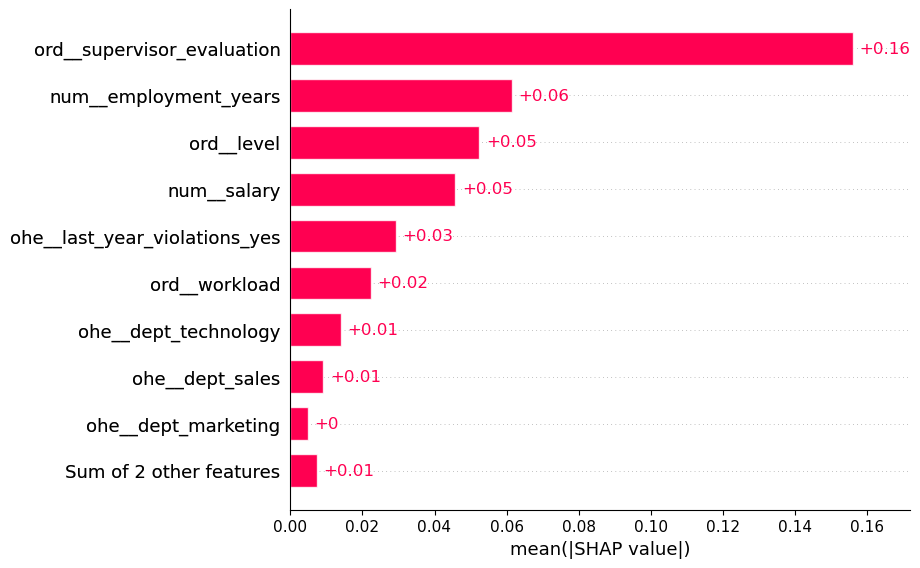

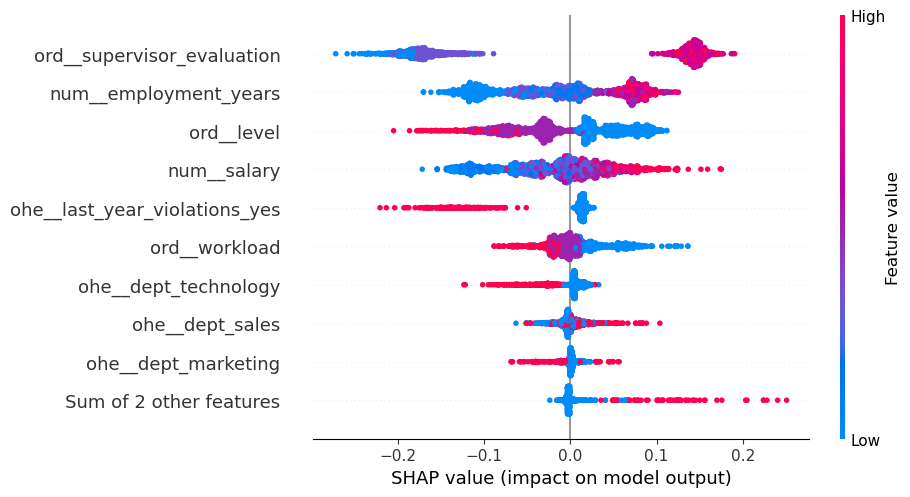

In [ ]:
# bring out the prepared data and wrap it in a dataframe for the values of Shapley
X_test_preprocessed = data_preprocessor.transform(X_test)

preprocessed_feature_names = data_preprocessor.get_feature_names_out()
best_model = grid_search.best_estimator_

# make a dataframe
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_feature_names)

# build a graph and a diagram of Shapley values
explainer = shap.Explainer(best_model.named_steps['models'],X_test_preprocessed_df)
shap_values = explainer(X_test_preprocessed_df,check_additivity = False)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values) 
plt.show()

## Task 1. Conclusion
<a id='Task-1.-Conclusion'></a> 
[Back to content](#To-content) 


A unified pipeline was formed for coding categorical data using OneHotEncoder and OrdinalEncoder, as well as standardizing quantitative data using MinMaxScaler and Standardscaler. The models chosen for training and prediction - DecisionTreeRegressor (with hyperparameter tuning of the depth of splitting levels from 2 to 20 and the maximum number of features at splitting evaluation from 2 to all 11), KNeighborsRegressor (with hyperparameter tuning of the number of neighbors from 2 to 20), LinearRegression (without hyperparameter tuning), SVR (with hyperparameter tuning as main kernels 'rbf', 'sigmoid', 'poly').  

As a result of training and selection, the model based on DecisionTreeRegressor with parameters max_depth=13, max_features=11 was selected, which showed the SMAPE metric considering cross-validation: -14.968880604776212 and on the test set: 14.50315484727758, corresponding to the task conditions.

Upon analyzing the importance of features by Shapley values, the most significant are:

* The assessment of the manager (the higher it is, the higher the target feature),
* The number of years worked (the more, the higher the target feature),
* The level of position (the lower, the higher job satisfaction),
* Salary level (the higher, the higher job satisfaction).

During training, good results showed models based on DecisionTreeRegressor (top-5 at least, with different parameter values), this may be due to:

* Non-linear dependencies: decision trees work well with non-linear dependencies between features and the target variable. Above we saw that there are no linear dependencies between input features and the target variable. Therefore, decision trees can better capture non-linear dependencies compared to linear regression or KNeighborsRegressor.

* Handling outliers: Decision Trees are relatively robust to outliers, which we have in the class of high-paid senior employees.

* Feature combination: Decision Trees can efficiently combine features to create complex conditions for making decisions, which may be useful if individual features are weakly correlated with the target variable, but their combinations give better results.

* Flexibility and hyperparameter tuning: decision trees have many hyperparameters (tree depth, minimum number of samples in a leaf, minimum number of samples required to split an internal node, etc.) that can be adjusted for optimization of performance, we used two + different variants of normalizing quantitative data. Grid search could find optimal parameters for decision trees, which led to better results.

<a id='Task-2.-Loading-data'></a>
## Task 2: Loading Data
[Back to contents](#To-contents)

In [ ]:
# import data for task 2
try:
    data2_train = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_2/train_quit.csv')
    data2_test_f = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_2/test_features.csv') 
    data2_test_t = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_8_HR(Sborniy)/Задача_2/test_target_quit.csv')
except:
    data2_train = pd.read_csv('/datasets/train_quit.csv')
    data2_test_f = pd.read_csv('/datasets/test_features.csv')
    data2_test_t = pd.read_csv('/datasets/test_target_quit.csv')    

In [ ]:
# look at the data
get_info(data2_train)
get_info(data2_test_f)
get_info(data2_test_t);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes


**Conclusion**

Based on preliminary assessment of the loaded data, corrections to column names and text values are not required, conversion of data types to correct ones for convenient analysis is also not needed, but it's possible to convert int64/float64 to int32/float32 for memory saving. Additionally, checks should be performed on the original data for missing and duplicate values in order to eliminate them subsequently.

<a id='Task-2.-Data-preprocessing'></a>
## Task 2. Data Preprocessing
[Back to content](#To-contents)

One by one, we will consider and correct (if necessary) all the comments from the previous section's conclusion:

In [38]:
for column in data2_train.columns:
    display(data2_train[column].unique())

array([723290, 814010, 155091, ..., 536432, 692133, 853842])

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

array(['middle', 'junior', 'sinior'], dtype=object)

array(['high', 'medium', 'low'], dtype=object)

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10])

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array([4, 1, 3, 5, 2])

array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400])

array(['no', 'yes'], dtype=object)

In [ ]:
# replace mistakes in the level column
data2_train['level'] = data2_train['level'].replace('sinior', 'senior')

# change numerical types of data to less voluminous
data1_train[['id','employment_years','supervisor_evaluation','salary']] = data1_train[['id','employment_years','supervisor_evaluation','salary']].astype(np.int32)


In [ ]:
# check also data in test set of input features
for column in data2_test_f.columns:
    display(data2_test_f[column].unique())

array([485046, 686555, 467458, ..., 305653, 160233, 771859])

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array([5, 4, 3, 1, 2])

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400])

In [ ]:
# replace spaces with NaN
data2_test_f[['dept','workload']] = data2_test_f[['dept','workload']].replace(' ', np.nan)

# and replace missing values with the most frequent ones, using the same pipeline
si_pipe.fit(data2_train[['dept','level','workload']])
data2_test_f[['dept','level','workload']] = si_pipe.transform(data2_test_f[['dept','level','workload']])

# replace typos in the level column
data2_test_f['level'] = data2_test_f['level'].replace('sinior', 'senior')

# change the data type of the columns to the smallest possible
data2_test_f[['id','employment_years','supervisor_evaluation','salary']] = data2_test_f[['id','employment_years','supervisor_evaluation','salary']].astype(np.int32)


In [ ]:
# print checks after changes
display(data2_test_f['level'].unique(),
        data2_test_f.isna().sum())
data2_test_f.info()

array(['junior', 'middle', 'senior'], dtype=object)

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int32 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int32 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int32 
 8   salary                 2000 non-null   int32 
dtypes: int32(4), object(5)
memory usage: 109.5+ KB


In [ ]:
# in the third dataset, we change the types of numerical data
data2_test_t['id'] = data2_test_t['id'].astype(np.int32)

data2_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int32 
 1   quit    2000 non-null   object
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


In [ ]:
# check that all id of test input features match the target, count the matches
data2_test_t['id'].isin(data2_test_f['id']).sum()

2000

In [ ]:
# and sort by id to avoid random order errors
data2_test_t = data2_test_t.sort_values(by='id').reset_index(drop=True)
data2_test_f = data2_test_f.sort_values(by='id').reset_index(drop=True)

display(data2_test_t.head(),
        data2_test_f.head())

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [ ]:
# check for duplicates in all three dataframes
display(data2_train.duplicated().sum(),
        data2_test_f.duplicated().sum(),
        data2_test_t.duplicated().sum())

0

0

0

**Conclusion**

As part of data preprocessing for Task 2, the following were done:

- Several missing values were identified and replaced with the most frequently occurring values in that column.
- Typos in text values were corrected.
- Data types of numerical values were adjusted to less memory-intensive ones.
- A check was performed for explicit and implicit duplicates - none were found.
- The order of records in test dataframes was adjusted.

## Task 2. Exploratory Data Analysis
<a id='Task-2.-Exploratory-Data-Analysis'></a> 
[Back to content](#To-contents)

First, let's take a look at the standard statistics for the tables and distributions of the data:

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no


,id,employment_years,supervisor_evaluation,salary
count,4000.000,4000.000,4000.000,4000.000
mean,552099.284,3.701,3.475,33805.800
std,260158.031,2.542,1.004,15152.415
min,100222.000,1.000,1.000,12000.000
25%,327785.750,2.000,3.000,22800.000
50%,546673.000,3.000,4.000,30000.000
75%,781497.750,6.000,4.000,43200.000
max,999915.000,10.000,5.000,96000.000


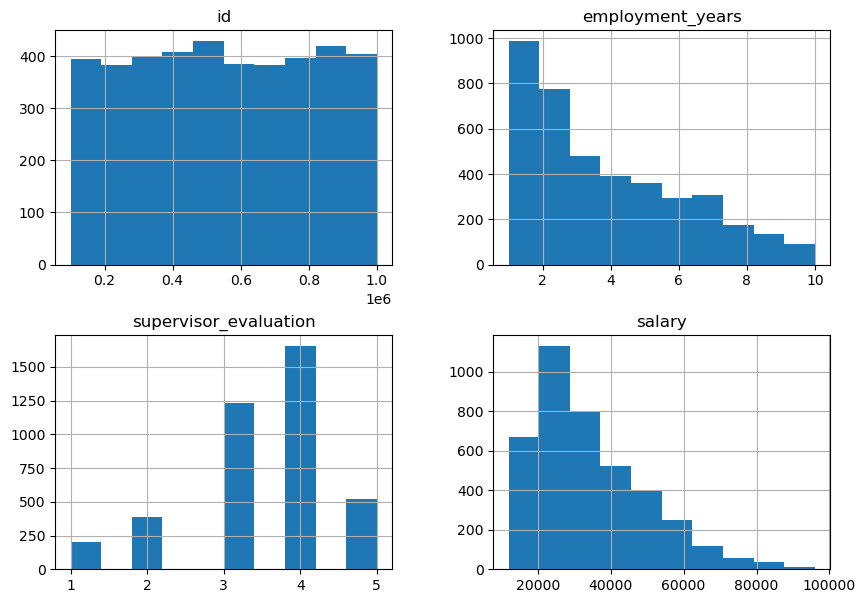

In [ ]:
display(data2_train.head(2))

# look at the distribution of data in general
data2_train.hist(figsize=(10, 7));
display(data2_train.describe())


In the table `data2_train`, the numerical data is distributed somewhat "abnormally", and the feature `supervisor_evaluation` appears to be a categorical ordered feature, since it has 5 values, which are ratings, and thus they have an ordered structure - from lower rating to higher. There are no outliers or abnormal values observed, let's take a look at these features separately and also at the categorical features.

Распределение количественных переменных



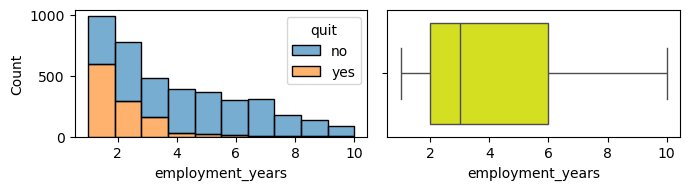

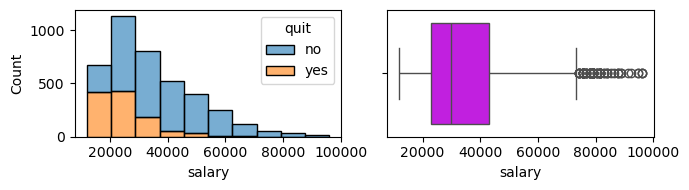

In [ ]:
# build histograms and boxplots for quantitative variables with target variable
columns_num = ['employment_years', 'salary']

print('Distribution of quantitative variables\n')

for index, column in enumerate(columns_num):
    hist_box(data2_train,column,hue='quit')

No critical anomalies in the quantitative features that need to be removed were detected, although the existing outliers in the "salary" feature more likely represent a separate group of experienced employees with high salaries, whose data will be important for training models. In general, the main mass of employees are junior employees with small experience and corresponding salary. Let's check this on categorical features:

In [49]:
data2_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


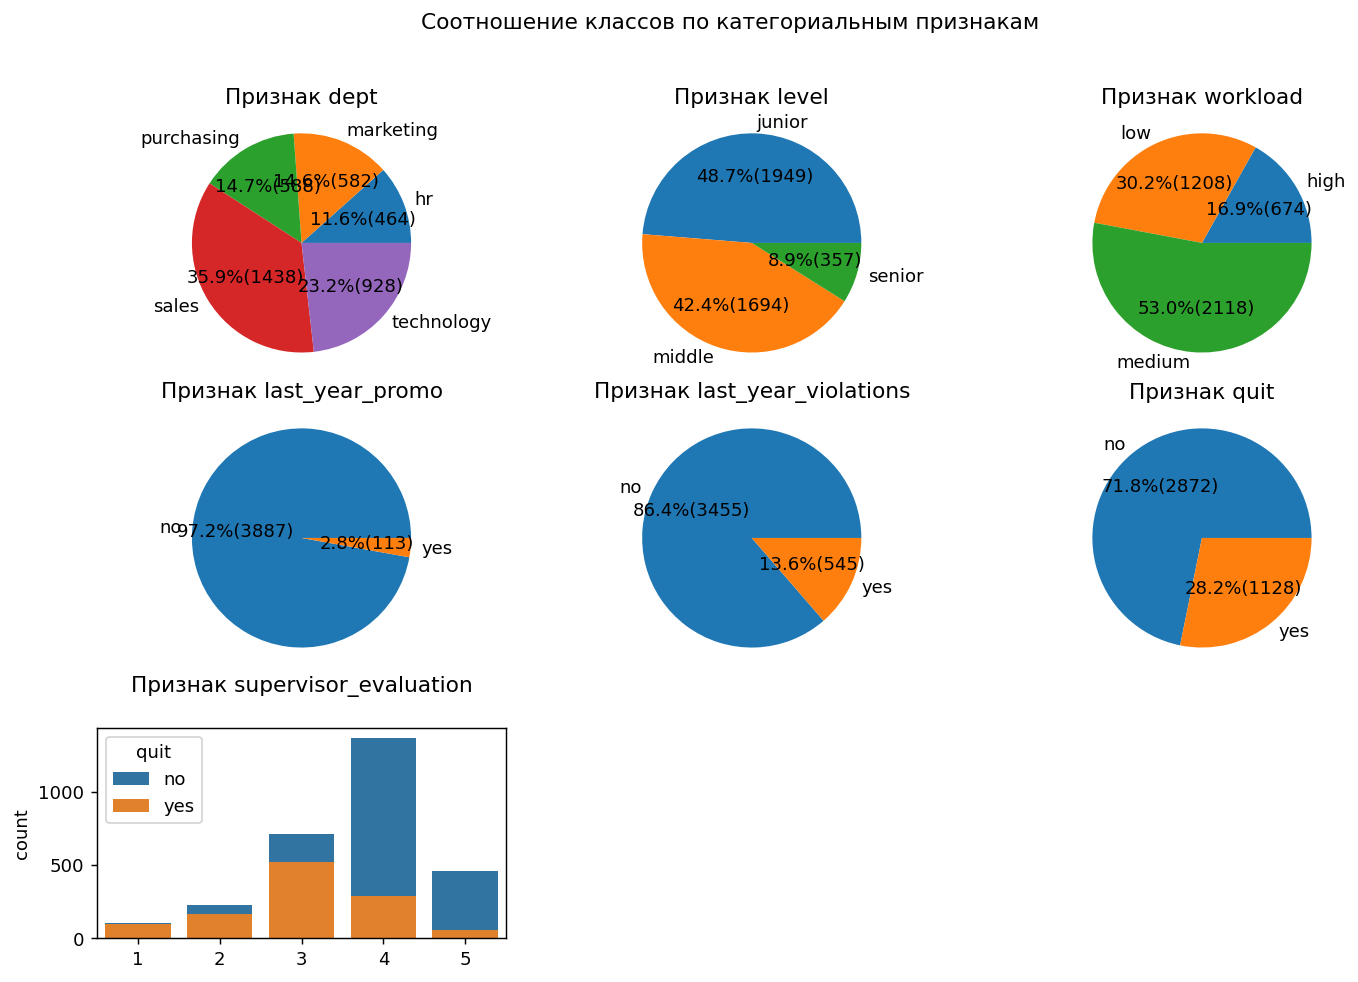

In [ ]:
# build pieplot on categorical data
columns_cat = ['dept', 'level','workload','last_year_promo','last_year_violations','quit']

plt.figure(figsize=[13, 8], dpi=130)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.suptitle('The distribution of classes by categorical features', y=1)

for i,column in enumerate(columns_cat):
    
    plt.subplot(3,3,i+1)
    pieplot(data2_train,column)

plt.subplot(3,3,7)
sns.countplot(data=data2_train,x='supervisor_evaluation', hue='quit', dodge=False)
plt.title('Feature supervisor_evaluation', pad=20)
plt.xlabel('')
plt.show()

We will also immediately check the test data for anomalies:

Распределение количественных переменных



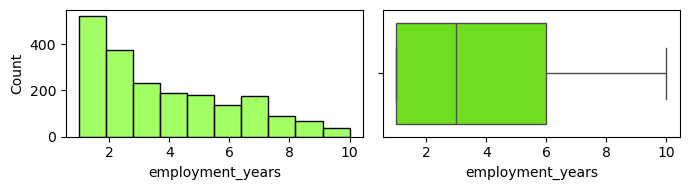

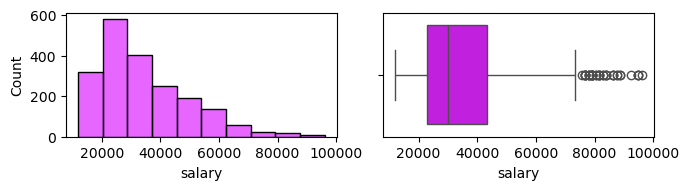

In [ ]:
# build a histogram and boxplot for quantitative variables with a split by the target variable
columns_num = ['employment_years', 'salary']

print('Distribution of the quantitative variables\n')

for index, column in enumerate(columns_num):
    hist_box(data2_test_f,column)

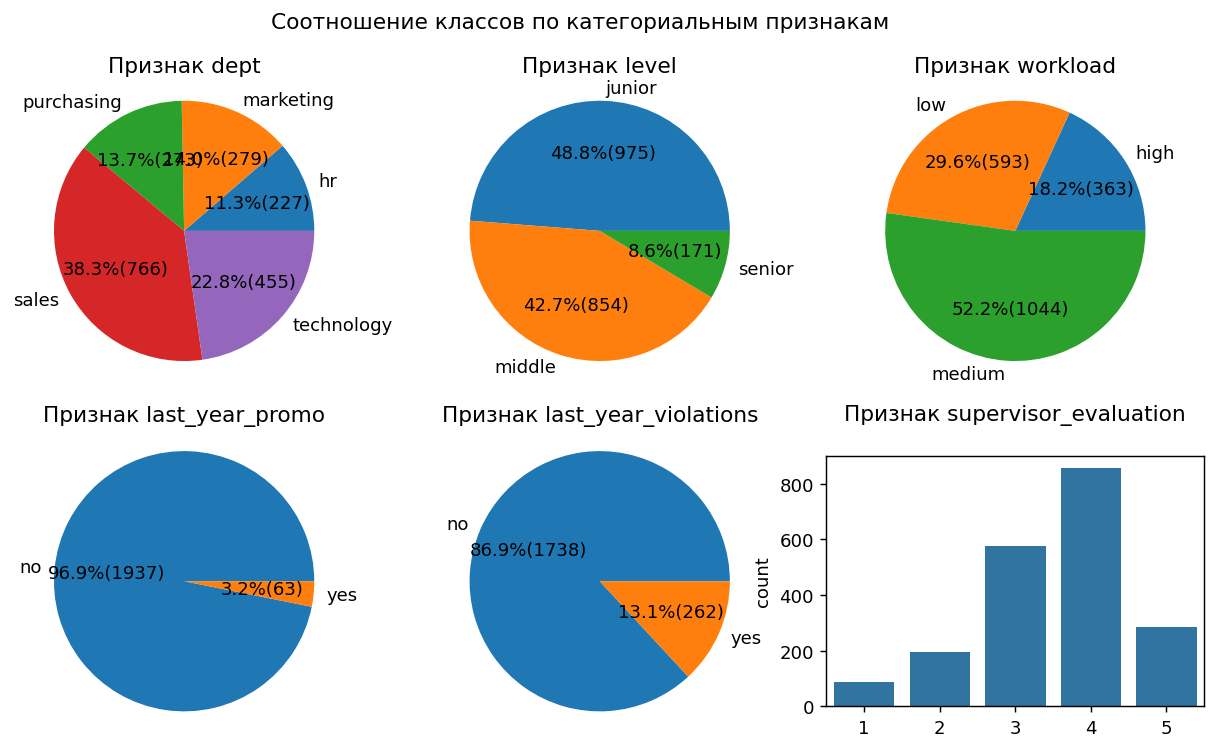

In [ ]:
# build pie plots for categorical data
columns_cat = ['dept', 'level','workload','last_year_promo','last_year_violations']

plt.figure(figsize=[12, 6], dpi=130)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.suptitle('The distribution of classes by categorical features', y=1)

for i,column in enumerate(columns_cat):
    
    plt.subplot(2,3,i+1)
    pieplot(data2_test_f,column)

plt.subplot(2,3,6)
sns.countplot(data=data2_test_f,x='supervisor_evaluation')
plt.title('Feature supervisor_evaluation', pad=20)
plt.xlabel('')
plt.show()

In [ ]:
# build correlation matrix for train set
# for this we will encode quit to numerical form and check the correctness
label_encoder = LabelEncoder()
data2_train['quit_priznak'] = label_encoder.fit_transform(data2_train['quit'])

data2_train.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,quit_priznak
0,723290,sales,middle,high,2,no,no,4,54000,no,0
1,814010,sales,junior,medium,2,no,no,4,27600,no,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,1
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0
5,699916,sales,junior,low,1,no,yes,3,18000,yes,1
6,417070,technology,middle,medium,8,no,no,2,44400,no,0
7,165489,sales,middle,low,4,no,no,5,19200,no,0
8,996399,marketing,middle,low,7,no,no,4,25200,no,0
9,613206,technology,middle,medium,2,no,no,3,45600,yes,1


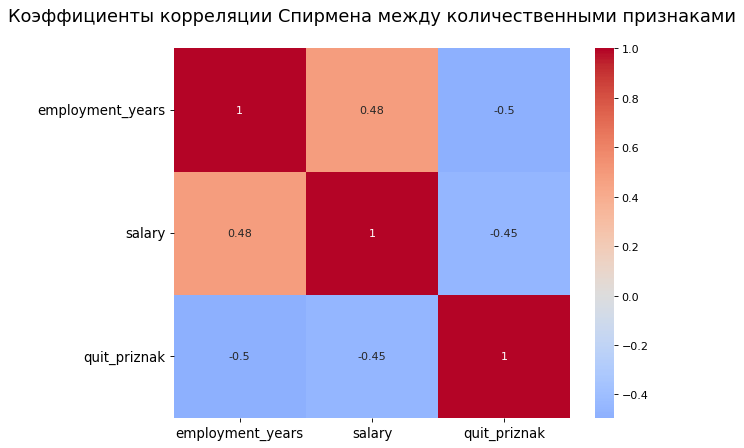

In [ ]:
# apply Spearman correlation(as we have non-normal distribution of features) and build heatmap
plt.figure(figsize=(8,6), dpi= 80)
sns.heatmap(data2_train[['employment_years', 'salary','quit_priznak']].corr(method='spearman'), 
                        xticklabels=data2_train[['employment_years', 'salary','quit_priznak']].corr(method='spearman').columns, 
                        yticklabels=data2_train[['employment_years', 'salary','quit_priznak']].corr(method='spearman').columns, 
                        cmap='coolwarm' , 
                        center=0, 
                        annot=True)

plt.title('The Pearson correlation coefficients between quantitative features\n', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

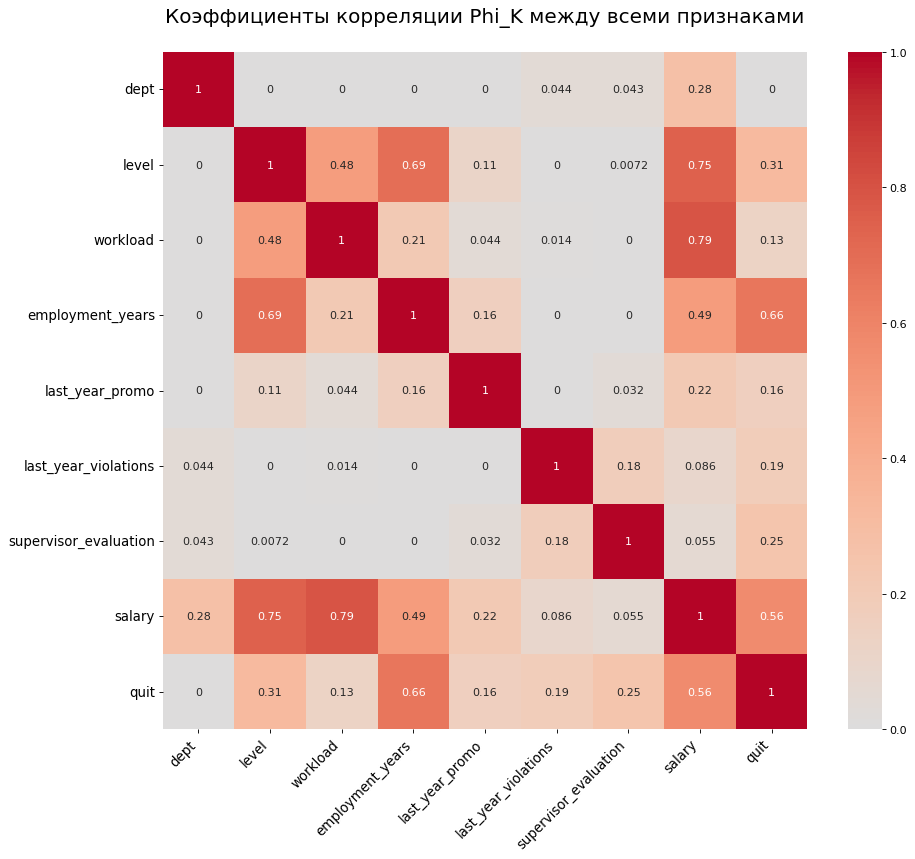

In [ ]:
# calculate phi_k correlation matrix for train data
temp = data2_train.drop(['id','quit_priznak'], axis=1)
phik_matrix = temp.phik_matrix(interval_cols=['employment_years', 'salary'])

# immediately look at the heatmap
plt.figure(figsize=(13,11), dpi= 80)
sns.heatmap(phik_matrix.values, xticklabels=phik_matrix.columns, yticklabels=phik_matrix.index, cmap='coolwarm', center=0, annot=True)

plt.title('PhiK correlation coefficients between all features\n', fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

Since the target variable in Task 2 is categorical, we can identify two groups of employees and analyze those who left using the other input features to form a portrait of an employee who left:

In [56]:
data2_train_quit = data2_train[data2_train['quit']=='yes']

data2_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128 entries, 3 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1128 non-null   int64 
 1   dept                   1128 non-null   object
 2   level                  1128 non-null   object
 3   workload               1128 non-null   object
 4   employment_years       1128 non-null   int64 
 5   last_year_promo        1128 non-null   object
 6   last_year_violations   1128 non-null   object
 7   supervisor_evaluation  1128 non-null   int64 
 8   salary                 1128 non-null   int64 
 9   quit                   1128 non-null   object
 10  quit_priznak           1128 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 105.8+ KB


Распределение количественных переменных
 по классу уволившихся сотрудников


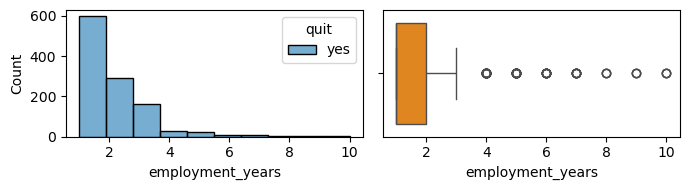

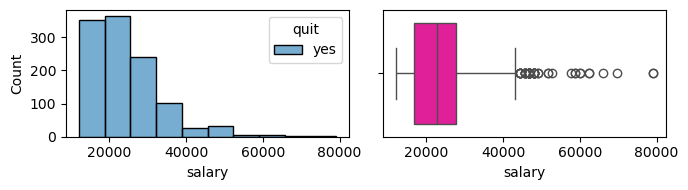

In [ ]:
# build histograms and boxplots for the 'quit' class
columns_num = ['employment_years', 'salary']

print('The distribution of quantitative variables\n by class of employees who left')

for index, column in enumerate(columns_num):
    hist_box(data2_train_quit,column,hue='quit')

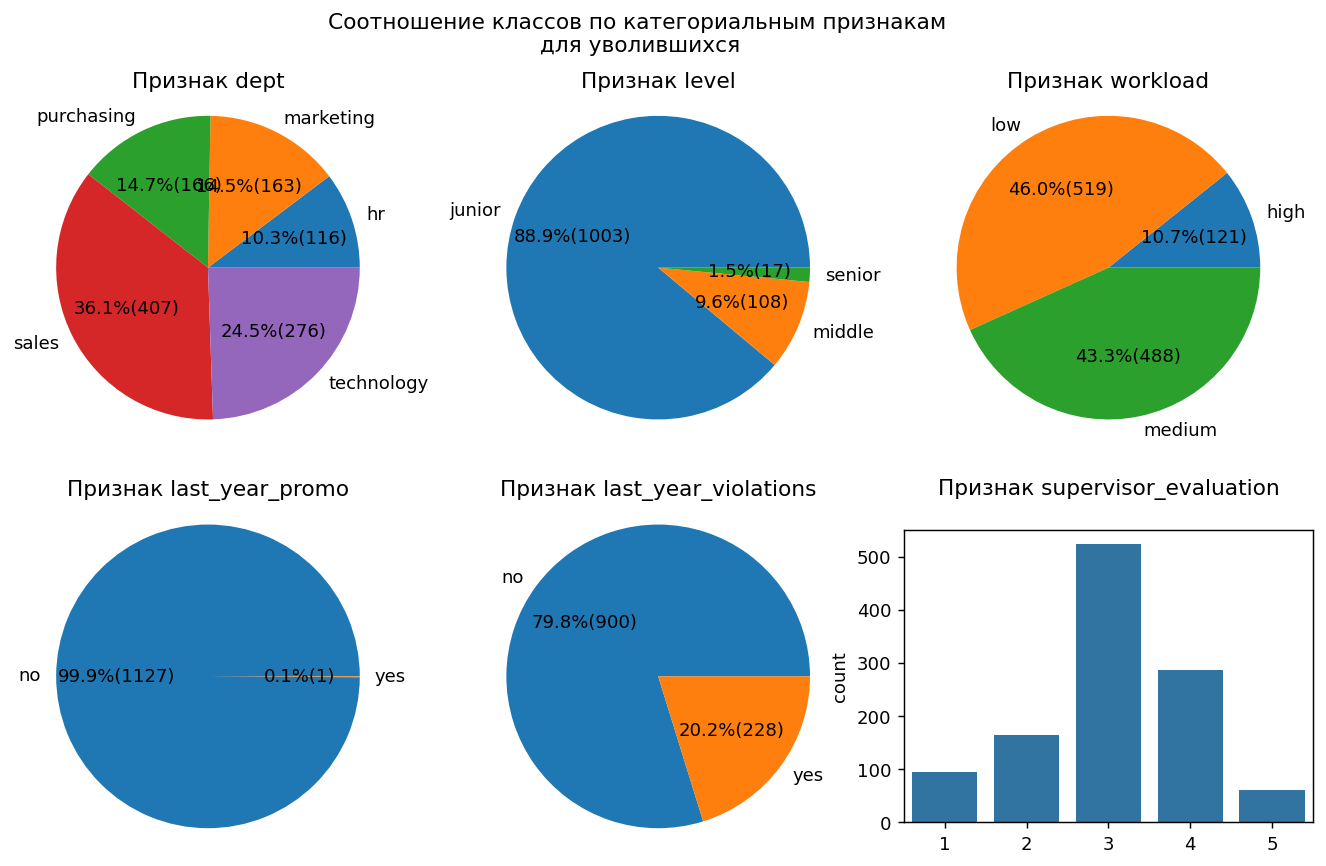

In [ ]:
# build pie plots for categorical data for quitters
columns_cat = ['dept', 'level','workload','last_year_promo','last_year_violations']

plt.figure(figsize=[13, 7], dpi=130)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.suptitle('The distribution of classes by\n categorical features for those who left', y=1)

for i,column in enumerate(columns_cat):
    
    plt.subplot(2,3,i+1)
    pieplot(data2_train_quit,column)

plt.subplot(2,3,6)
sns.countplot(data=data2_train_quit,x='supervisor_evaluation')
plt.title('Feature supervisor_evaluation', pad=20)
plt.xlabel('')
plt.show()

In [ ]:
# compaare the salaries of the employees who left with the remaining ones
data2_train.groupby('quit')['salary'].mean()

quit
no    37702.228
yes   23885.106
Name: salary, dtype: float64

In [60]:
data2_test_f.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


Let's check the claim by our colleague analysts that the level of employee satisfaction with their work in the company affects whether they will leave or not, based on the test dataset with the added job_satisfaction_rate feature from the previous task.

Visualize and compare the distributions for those who left and remained employees. Use the data with both target features of the test dataset.

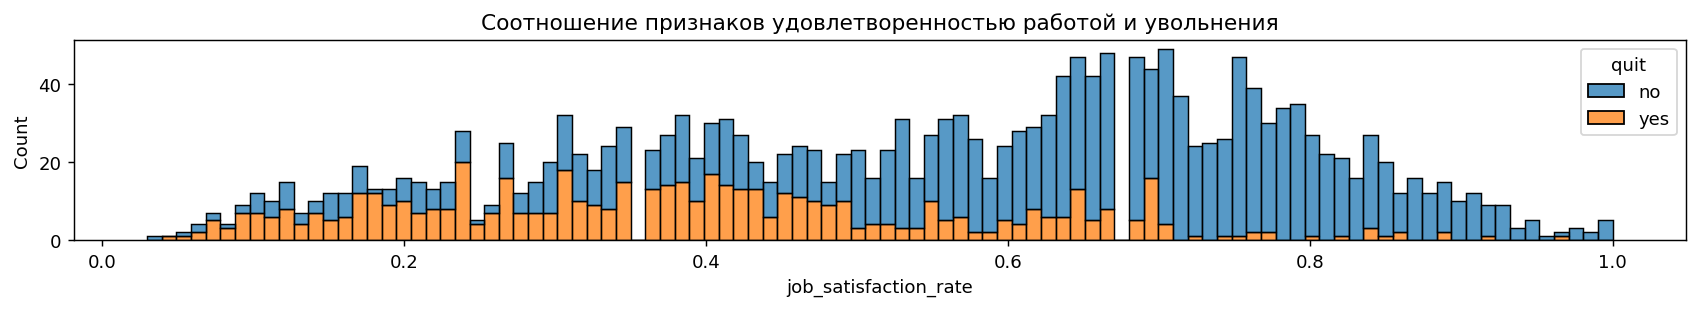

In [ ]:
# build a histogram of the job_satisfaction_rate feature from the previous test sample with the resignation attribute from the current test sample

plt.figure(figsize=[16, 2], dpi=130)
plt.title('The relationship between job satisfaction and turnover')
sns.histplot(x=data1_test_t['job_satisfaction_rate'], bins=100, hue=data2_test_t['quit'], multiple='stack', color='navy')
plt.show()

In [ ]:
# compare the distribution of the job_satisfaction_rate for the employees who left and stayed
# with help of the statistical test

# highlight the data of the two samples
employee_fired = data1_test_t[(data1_test_t['id'] == data2_test_t['id'])&(data2_test_t['quit']=='yes')]['job_satisfaction_rate']
employee_stayed = data1_test_t[(data1_test_t['id'] == data2_test_t['id'])&(data2_test_t['quit']=='no')]['job_satisfaction_rate']

# calculate the mean for the job_satisfaction_rate for each of the samples
print(f'Average job satisfaction among those who left: {np.mean(employee_fired)}')
print(f'Average job satisfaction among those who remained: {np.mean(employee_stayed)}')

# set the level of statistical significance
alpha = 0.05

results = st.ttest_ind(employee_fired,employee_stayed, alternative = 'two-sided')
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

Среднее значение удовлетворенности работой среди уволившихся: 0.3877127766609192
Среднее значение удовлетворенности работой среди оставшихся: 0.6120404005050659
p-значение:  1.2311330865600129e-104
Отвергаем нулевую гипотезу


In [ ]:
# calculate the correlation coefficient between the job_satisfaction_rate and quit features
# for this, we will encode the quit feature in a numerical form and apply the Spearman correlation method
# as we cn see that distribution of the job_satisfaction_rate is not normal

data2_test_t['quit_priznak'] = label_encoder.transform(data2_test_t['quit'])

print('The Pearson correlation coefficient between the features job_satisfaction_rate и quit: ', \
      data1_test_t['job_satisfaction_rate'].corr(data2_test_t['quit_priznak'], method='spearman'))

Коэффициент корреляции Спирмена между признаками job_satisfaction_rate и quit:  -0.45745372179755656


In [ ]:
# calculate correlation with Phi_K
data2_test_t = data2_test_t.merge(data1_test_t, on='id', how='inner')

In [65]:
data2_test_t.head()

,id,quit,quit_priznak,job_satisfaction_rate
0,100298,no,0,0.800
1,100480,no,0,0.840
2,100503,no,0,0.790
3,100610,no,0,0.750
4,100692,no,0,0.690


In [66]:
temp = data2_test_t.drop(['id','quit_priznak'], axis=1)

phik_matrix = temp.phik_matrix(interval_cols=['job_satisfaction_rate','id'])

phik_matrix

,quit,job_satisfaction_rate
quit,1.000,0.610
job_satisfaction_rate,0.610,1.000


**Conclusion**

The quantitative data of the training sample are not normally distributed, and outliers exist by the salary feature, which confirms the presence of a segment of high-paid employees in the senior category. Since the data are presented in strongly differing ranges, literally one feature from 1 to 10, the second is measured in tens of thousands, it will be necessary to scale the data at the stage of preparation for training.

Categorical data have between 2 and 5 classes, with uneven distribution between them, features 'level', 'workload' and 'supervisor_evaluation' have an ordinal nature, so they need to be pre- encoded taking into account the order of categories (OrdinalEncoder), the other features are non-hierarchical and, taking into account the need to train a linear model, it is better to encode them using OHE (since the linear model is sensitive to ordinal coding of non-ordinal categories).

The Spearman correlation coefficients between quantitative data and the target feature showed a moderate link: with the feature of worked years at 0.5, with the salary feature at 0.45. At the same time, when checking the level of correlation by the Phi_K metric, significant links of the target feature were found only with the features of the number of worked years (0.66) and salary (0.51), position level (0.31), with ordinal features correlations are less significant. Among themselves, significant links between the input features were found only between the position level, salary, number of worked years and workload levels, but multicollinearity is not observed.

The input data of the test sample are distributed similarly to the training one, no additional comments.

Additionally, the input features were studied by class of fired employees and a typical portrait was compiled, according to which an employee who has been fired worked for up to 2 years inclusive, most likely in the sales or technologies department on junior positions, had low or average load, did not have promotions and mainly violations over the past year, and was evaluated by his supervisor at 3-4 points out of 5. The average salary of fired employees was 27.7 thousand against 37.7 thousand for those who remained.

Also, the hypothesis of a link between the feature of firing and the level of employee satisfaction with work was checked - the hypothesis was confirmed, the indicated links manifest themselves visually on the graph of distribution by the feature of job satisfaction rate with breakdown by the feature of firing, the Spearman correlation coefficient between these features was -0.45, according to Phi_K values, a correlation at the level of 0.61 was also identified.

Checking the average values of the job_satisfaction_rate feature for subgroups of fired and remaining employees using a statistical test showed the possibility of rejecting the null hypothesis of equality of mean values, i.e., the probability that satisfaction with work of these two groups of employees has the same distribution is statistically insignificant (these are different groups of employees by the feature of satisfaction).

## Task 2. Adding a new input feature
<a id='Task-2.-Adding-a-new-input-feature'></a> 
[Back to Contents](#To-contents) 

With consideration of the identified link between the previously calculated feature job_satisfaction_rate and the target feature quit, it makes sense to enrich the training sample with input features from the best model from Task 1, and the test sample with input features from the test sample in Task 1:

In [67]:
data2_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,quit_priznak
0,723290,sales,middle,high,2,no,no,4,54000,no,0
1,814010,sales,junior,medium,2,no,no,4,27600,no,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,1
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0


In [ ]:
# prepare data for prediction of job_satisfaction_rate
X_prepare = data2_train.drop(['id','quit','quit_priznak'], axis=1)

# predict the feature
data2_train['job_satisfaction_rate'] = grid_search.best_estimator_.predict(X_prepare)

# check the data
display(data2_train.head(),
        data2_train.shape,
        data2_train.isna().sum())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,quit_priznak,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0,0.635
1,814010,sales,junior,medium,2,no,no,4,27600,no,0,0.816
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0,0.364
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,1,0.380
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0,0.690


(4000, 12)

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
quit_priznak             0
job_satisfaction_rate    0
dtype: int64

In [ ]:
# check the correlation between the added feature and the target
print('Spearman correlation coefficient between the features job_satisfaction_rate и quit: ', \
      data2_train['job_satisfaction_rate'].corr(data2_train['quit_priznak'], method='spearman'))

Коэффициент корреляции Спирмена между признаками job_satisfaction_rate и quit:  -0.3953503942032777


In [ ]:
# bring them into accordance and test sets
data2_test_t = data2_test_t.drop(['quit_priznak','job_satisfaction_rate'],axis=1)
data2_test_t.head()

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


In [71]:
data2_test_f['job_satisfaction_rate'] = data1_test_t['job_satisfaction_rate']
data2_test_f.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.800
1,100480,marketing,junior,low,4,no,no,4,16800,0.840
2,100503,purchasing,middle,high,5,no,no,4,55200,0.790
3,100610,sales,middle,medium,5,no,no,4,43200,0.750
4,100692,sales,middle,high,6,no,no,4,48000,0.690


## Task 2. Data Preparation
<a id='Task-2.-Data-Preparation'></a> 
[Back to Contents](#To-contents)

In [ ]:
# form the sets of data for training and testing with taking into account the already existing dataset for test data
X_train = data2_train.drop(['id','quit','quit_priznak'], axis=1)
y_train = pd.DataFrame(data2_train['quit'], columns=['quit'])
X_test = data2_test_f.drop('id', axis=1) 
y_test = data2_test_t.drop('id', axis=1) 
                  
# for this, we will encode the quit attribute in a numerical form and check the correctness
y_train['quit'] = label_encoder.fit_transform(y_train['quit'])
y_test['quit'] = label_encoder.transform(y_test['quit'])
    
    
display(X_train.head(),
       X_test.head(),
       y_train.head(),
       y_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.635
1,sales,junior,medium,2,no,no,4,27600,0.816
2,purchasing,middle,medium,5,no,no,1,37200,0.364
3,sales,junior,medium,2,no,yes,3,24000,0.380
4,marketing,junior,medium,2,no,no,5,25200,0.690


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,hr,junior,low,2,no,no,4,19200,0.800
1,marketing,junior,low,4,no,no,4,16800,0.840
2,purchasing,middle,high,5,no,no,4,55200,0.790
3,sales,middle,medium,5,no,no,4,43200,0.750
4,sales,middle,high,6,no,no,4,48000,0.690


,quit
0,0
1,0
2,0
3,1
4,0


,quit
0,0
1,0
2,0
3,0
4,0


In [ ]:
# check the display of the original classes and their codes
print("Classes and its codes:")
for cls, code in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{cls} -> {code}")


Классы и их коды:
no -> 0
yes -> 1


In [ ]:
# make list of column names
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level','workload','supervisor_evaluation']
num_columns = ['employment_years','salary','job_satisfaction_rate']

# make a pipeline for preparing features from the list ohe_columns: filling in the gaps and OHE encoding
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# make a pipeline for preparing features from the list ord_columns: filling in the gaps and Ordinal-encoding
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low','medium','high'],
                    [1,2,3,4,5]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# make a general pipeline for preparing data
data_preprocessor_1 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [ ]:
# count the number of features after preliminary data processing
max_features = data_preprocessor_1.fit_transform(X_train).shape[1]
display(max_features)

# look at the column names after encoding
display(data_preprocessor.get_feature_names_out())

12

array(['ohe__dept_marketing', 'ohe__dept_purchasing', 'ohe__dept_sales',
       'ohe__dept_technology', 'ohe__last_year_promo_yes',
       'ohe__last_year_violations_yes', 'ord__level', 'ord__workload',
       'ord__supervisor_evaluation', 'num__employment_years',
       'num__salary'], dtype=object)

## Task 2. Training Models
<a id='Task-2.-Training-Models'></a> 
[Back to Contents](#To-contents)

In [ ]:
%%time

# set the constant
RANDOM_STATE = 42

# make the final pipeline: data preparation and model
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    #('selector', SelectKBest(f_classif)),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# set  the hyperparameters for the grid search
param_grid_1 = [
    # dictionary for DecisionTreeRegressor()
    {
        #'selector__k': range(2,6), 
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,max_features+1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # dictionary for KNeighborsRegressor() 
    {
        #'selector__k': range(2,6), 
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for LinearRegression()
    {
        #'selector__k': range(2,6), 
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # dictionary for SVR()
    {
        #'selector__k': range(2,6), 
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['rbf','sigmoid','poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


# full grid search
grid_search_1 = GridSearchCV(
    pipe_final_1, 
    param_grid_1, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,

)

grid_search_1.fit(X_train, np.ravel(y_train))


CPU times: user 5.2 s, sys: 389 ms, total: 5.59 s
Wall time: 51.4 s


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__kernel': ['rbf', 'sigmoid', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [ ]:
print('Best model and its parameters:\n\n', grid_search_1.best_estimator_)
print ('Metric of the best model considering cross-validation:', grid_search_1.best_score_)

# check the model on the test set
# calculate the prediction on the test set
y_test_pred = grid_search_1.predict_proba(X_test)[:,1]
print(f'Metric ROC-AUC on the test sample: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                  

In [ ]:
# for comparison, let's look at the top 5 models
results = grid_search_1.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# unite scores and parameters
all_models = list(zip(mean_test_scores, params))

# sort models by scores in descending order
all_models.sort(key=lambda x: x[0], reverse=True)

all_models[0:5]

[(0.93010485407726,
  {'models': DecisionTreeClassifier(random_state=42),
   'models__max_depth': 5,
   'models__max_features': 9,
   'preprocessor__num': StandardScaler()}),
 (0.93010485407726,
  {'models': DecisionTreeClassifier(random_state=42),
   'models__max_depth': 5,
   'models__max_features': 9,
   'preprocessor__num': MinMaxScaler()}),
 (0.93010485407726,
  {'models': DecisionTreeClassifier(random_state=42),
   'models__max_depth': 5,
   'models__max_features': 9,
   'preprocessor__num': 'passthrough'}),
 (0.9283954274651641,
  {'models': SVC(probability=True, random_state=42),
   'models__kernel': 'rbf',
   'preprocessor__num': StandardScaler()}),
 (0.9279475797406487,
  {'models': KNeighborsClassifier(),
   'models__n_neighbors': 14,
   'preprocessor__num': StandardScaler()})]

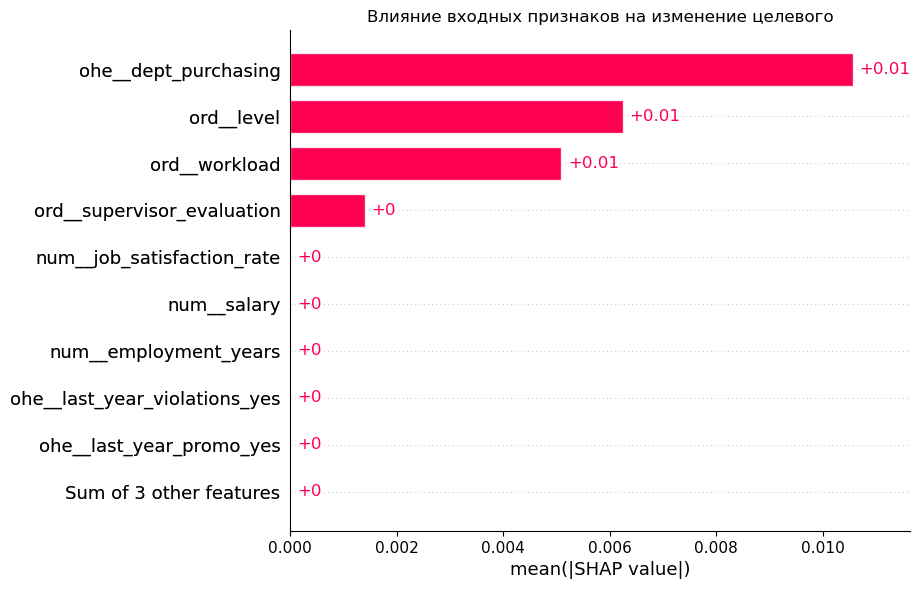

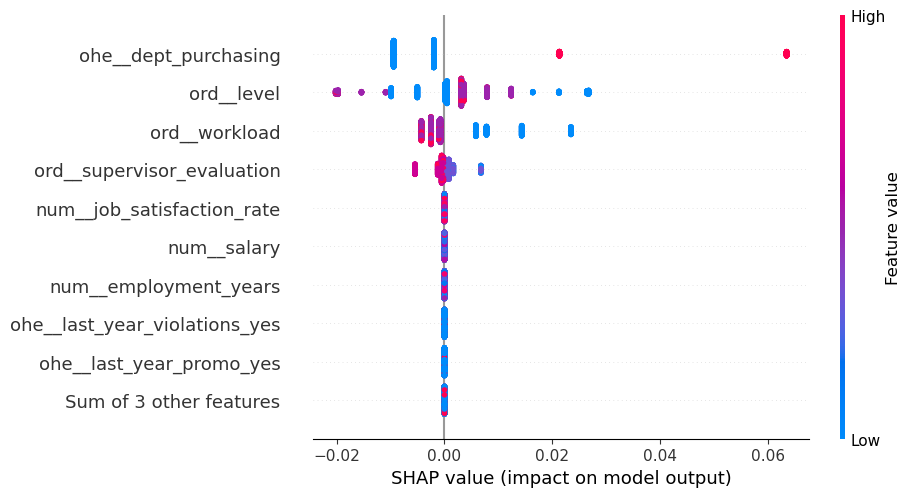

In [ ]:
# bring out the prepared data and wrap it in a dataframe for the values of Shapley
X_test_preprocessed = data_preprocessor_1.transform(X_test)

preprocessor_1 = best_model.named_steps['preprocessor']
preprocessed_feature_names_1 = data_preprocessor_1.get_feature_names_out()
best_model = grid_search_1.best_estimator_

# make a dataframe
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_feature_names_1)

# build a graph and a diagram of the values of Shapley
explainer_1 = shap.TreeExplainer(best_model.named_steps['models'],X_test_preprocessed_df)
shap_values_1 = explainer_1(X_test_preprocessed_df,check_additivity = False)
shap_values_class_1 = shap_values_1[:, :, 1]

plt.title('Impact of input features on change in target variable')
shap.plots.bar(shap_values_class_1)
shap.plots.beeswarm(shap_values_class_1) 
plt.show()

## Task 2. Conclusion
<a id='Task-2.-Conclusion'></a> [Back to the contents](#To-contents) 

As a result of the trained models - DecisionTreeClassifier (with tuning of two hyperparameters max_depth and max_features), KNeighborsClassifier (with tuning of the k_neighbors hyperparameter), LogisticRegression (with tuning of the regularization parameter C), SVC (with tuning of the main kernels), the best result was shown by DecisionTreeClassifier with a ROC_AUC_score metric at cross-validation level 0.93 and on test sample 0.928, which exceeds the task-set threshold of 0.91.

As previously mentioned in the conclusions for Task 1, the reasons why decision trees turned out to be the most effective for evaluating and predicting the considered data in these tasks are:

- Non-linear dependencies
- Working with outliers
- Combination of features
- Flexibility and tuning of hyperparameters.

According to the values of SHAP, the highest importance for predicting probabilities belonging to class 1 (fired) are:
- dept_purchasing (presence of feature increases probability of firing)
- level
- workload (decrease in feature increases probability of firing)
- supervisor_evaluation (decrease in feature increases probability of firing)

## General Conclusion
<a id='General-conclusion'></a>
[Back to contents](#K-scontents)

The goal of this project was to analyze collected data for subsequent prediction of the target quantitative indicator "employee job satisfaction level" (Task 1) and classification of employees by their tendency to quit (Task 2). To achieve this, it was necessary to train several types of machine learning models and select the best one that meets established thresholds based on SMAPE < 15 for Task 1 and ROC-AUC >= 91 for Task 2.

Since both tasks were based on similar data (some datasets overlapped) during the **data loading** and **preprocessing** stages, the following actions were performed:

* Several missing values were detected and replaced with the most frequent value in the column
* Textual errors were corrected
* Numerical data types were adjusted to be less resource-intensive
* A check for explicit and implicit duplicates was performed - none were found
* The order of records in test datasets was corrected

**Research Analysis for Task 1 Data** found that the quantitative data in the training dataset are not normally distributed, outliers exist in the "salary" feature, confirming the presence of a segment with high-paying senior employees. Additionally, since the data are presented in strongly differing ranges, literally one feature from 0 to 1, another from 1 to 10, and the third is measured in tens of thousands, there is a need to scale the data.

Categorical data have from 2 to 5 classes, unevenly distributed between classes. The features 'level', 'workload', 'supervisor_evaluation' have an ordinal nature, so they need to be pre-coded considering the order of categories (OrdinalEncoder). Other features are non-hierarchical and taking into account the need to train including linear models, it is better to encode them using OHE (since a linear model is sensitive to ordinal encoding of non-ordinal categories).

The Pearson correlation coefficients between quantitative data and the target feature showed an insignificant link: with the "seniority" feature at 0.22, with the "salary" feature at 0.13. At the same time, checking the correlation level by the Phi_K metric showed that there is a significant link of the target feature only with the supervisor's assessment (0.76) and the number of violations (0.56), with the "seniority" feature at the level of 0.33. Among the input features, significant links are only between the position level, salary level, seniority and workload levels, but multicollinearity is not observed. Non-linearity in links between input features and target was not detected. The data in the test sample are distributed similarly to the training, no additional comments.

On the next step for **data preparation** and **model training**, a unified pipeline was formed for coding categorical data using OneHotEncoder and OrdinalEncoder, as well as standardizing quantitative data using MinMaxScaler and Standardscaler. Models chosen for training and prediction - DecisionTreeRegressor (with hyperparameter tuning depth levels 2 to 20 and maximum number of features at evaluation splitting from 2 to all 11), KNeighborsRegressor (with hyperparameter tuning number of neighbors from 2 to 20), LinearRegression (without hyperparameter tuning), SVR (with hyperparameter tuning in the form of main kernels 'rbf', 'sigmoid', 'poly').

As a result of training and selection, a model based on DecisionTreeRegressor with parameters max_depth=13, max_features=11 was selected, which showed SMAPE metric considering cross-validation: -14.968880604776212 and on test sample: 14.50315484727758, corresponding to the conditions of the task. At analyzing feature importance by Shephard values, most significant are supervisor's evaluation (the higher it is, the higher the target), seniority (the more, the higher the target), position level (the lower, the higher job satisfaction) and salary level (the higher, the higher job satisfaction).

During training, best results showed models based on DecisionTreeRegressor (top-5 at least, with different parameter values), this may be due to:

* Non-linear dependencies: decision trees work well with non-linear dependences between features and target variable. Above we found that there are no linear dependences between input features and target. Therefore, decision trees can better capture non-linear dependences compared to linear regression or KNeighborsRegressor.

* Handling outliers: Decision Trees are relatively robust to outliers, which we have in the class of high-paying senior employees.

* Feature combination: Decision Trees can efficiently combine features to create complex conditions for making decisions, which may be useful if individual features are weakly correlated with the target variable, but their combinations give better results.

* Flexibility and hyperparameter tuning: Decision Trees have many hyperparameters (tree depth, minimum number of samples in a leaf, minimum number of samples required to split an internal node, etc.), which can be tuned for optimization. We used two + different normalization variants for quantitative data. Grid search could find optimal parameters for decision trees, leading to better results.

Further **analysis of data** for Task 2 revealed that the quantitative data in the training set were non-normal and had outliers on the salary feature, confirming the presence of a segment of high-income senior employees.

Due to the strongly differing ranges: one feature was between 1 and 10, while another measured in tens of thousands, scaling of the data became necessary.

Categorical data had from 2 to 5 classes with uneven distribution between them. The 'level','workload','supervisor_evaluation' features had an ordinal nature, so it is necessary to encode them considering the order of categories (OrdinalEncoder). Other features were non-ordinal and, given the need to train a linear model as well, it is better to code them using OHE (since linear models are sensitive to ordered encoding for non-ordered categories).

Spearman correlation coefficients between quantitative data and the target feature showed medium-strength links: 0.5 with the years of service feature, and 0.45 with the salary feature. When checking the correlation level by Phi_K metric, a significant link was only detected between the target feature and features such as years of service (0.66) and salary (0.51), as well as job level (0.31). The links with ordinal features were less significant.

Among the input features themselves, there were significant relationships only between job level, salary, years of service, and workload, but multicollinearity was not observed.

The input data in the test set were distributed similarly to the training set; no additional comments were made.

Additionally, we studied the input features by class for departing employees and compiled a typical portrait: an employee who had worked up to 2 years included, likely in sales or technology department at junior positions, with low or average workload, without promotions, and mainly disciplinary offenses over the previous year, and was evaluated by their supervisor as 3-4 points out of 5. The average salary for departing employees was 27.7 thousand against 37.7 thousand for those who remained.

We also checked the hypothesis about a link between the dismissal feature and employee job satisfaction level - the hypothesis was confirmed: the relationship between these features is visible on a graph of distribution by job satisfaction level with separation according to the dismissal feature, with Spearman correlation coefficient being -0.45, and by Phi_K metric values, a correlation at 0.61 level was detected.

Given the discovered connection between previously calculated employee job satisfaction rate (job_satisfaction_rate) and target feature quit, it was decided to enrich the training set of input features with predictions from the best model in Task 1, while adding this feature from the test set in Task 1 to the input features in the test set.

Within the framework of **data preparation** and subsequent **model training**, a unified pipeline was established for encoding and scaling features analogous to Task 1. Four types of models were trained for prediction: 
- DecisionTreeClassifier (with two hyperparameter searches, max_depth and max_features)
- KNeighborsClassifier (with one hyperparameter search, k_neighbors)
- LogisticRegression (with one hyperparameter search, C regularization)
- SVC (with one main kernel parameter search)

The best result was achieved by the **DecisionTreeClassifier** with an ROC_AUC_score of 0.93 during cross-validation and 0.928 on the test dataset, exceeding the task threshold of 0.91.

Considering the similarity between data from Task 1, factors contributing to the maximum effectiveness of decision trees (3 out of 5 models in the top-5) are:

* Non-linear dependencies
* Handling outliers
* Combination of features
* Flexibility and hyperparameter tuning

According to SHAP values, the highest importance for predicting the probability of belonging to class 1 (separated employees) is attributed to:

* dept_purchasing (presence of feature increases the likelihood of separation)
* level
* workload (decrease in feature increases the likelihood of separation)
* supervisor_evaluation (decrease in feature increases the likelihood of separation)

For business process optimization purposes, it is recommended to focus on:

* Improving employee satisfaction: pay attention to supervisor evaluations (most influential factor) and develop young employees, as they are most prone to workplace depression. Other employees may have a more interesting task scope, higher recognition, and positive feedback from supervisors, positively affecting their job satisfaction.

* Reducing turnover: focus on employees in the purchasing department (participation in this department increases separation likelihood), workload levels – low workload decreases interest and increases separation likelihood (consider balancing tasks with more demanding, interesting projects). Additionally, pay attention to supervisor evaluations as low scores decrease employee interest and increase separation likelihood. In such cases, conduct additional measures to boost engagement and productivity among employees.
